### Setup

Import Caffe and the usual modules.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import PCA

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import _init_paths
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.bbox_transform import clip_boxes, bbox_transform_inv
from fast_rcnn.test import _get_blobs
import caffe, os, sys, cv2

### Configure all the constants

Define net path, data path and so on.

In [2]:
DATA_PATH = '/mnt/wb/dataset/LINEMOD_3_PARAM/BG_PARAM_B'
FASTER_RCNN_ROOT = '/mnt/wb/project/py-faster-rcnn'

#CLASSES = ('__background__',
#           'ape', 'benchviseblue', 'bowl', 'cam', 'can', 
#           'cat', 'cup', 'driller', 'duck', 'eggbox', 
#           'glue', 'holepuncher', 'iron', 'lamp', 'phone')

CLASSES = ('__background__',
           'ape', 'cat', 'duck')

NETS = {'pose_zf_400k': ('ZF/faster_rcnn_end2end',
                  'linemod_pose_test.prototxt',
                  'linemod_pose_zf_iter_400000.caffemodel'),
        'sub_pose_zf_1000k': ('ZF/faster_rcnn_end2end',
                  'linemod_sub_pose_test.prototxt',
                  'linemod_sub_pose_zf_iter_1000000.caffemodel'),
        'ape_pose_zf_1000k': ('ZF/faster_rcnn_end2end',
                  'linemod_ape_pose_test.prototxt',
                  'linemod_ape_pose_zf_iter_1000000.caffemodel'),
        'apec2_pose_zf_200k': ('ZF/faster_rcnn_end2end',
                  'linemod_apeb_pose_test.prototxt',
                  'linemod_apec_pose_zf_2_iter_200000.caffemodel'),
        'apec_pose_zf_200k': ('ZF/faster_rcnn_end2end',
                  'linemod_apeb_pose_test.prototxt',
                  'linemod_apec_pose_zf_iter_200000.caffemodel'),
        'large3_pose_zf_5000k': ('ZF/faster_rcnn_end2end',
                  'linemod_3_pose_test.prototxt',
                  'linemod_3_pose_zf_2_iter_5000000.caffemodel'),
        'large3b_pose_zf_1000k': ('ZF/faster_rcnn_end2end',
                  'linemod_3_pose_test.prototxt',
                  'linemod_3b_pose_zf_2_iter_1000000.caffemodel'),
        'catb2_pose_zf_400k': ('ZF/faster_rcnn_end2end',
                  'linemod_apeb_pose_test.prototxt',
                  'linemod_catb_pose_zf_2_iter_400000.caffemodel')}

TO_BE_CLASS = CLASSES[1]
DATASETS = {'linemod_test': 
                (DATA_PATH + '/data/ImageSets/test.txt',
                 DATA_PATH + '/data/Images')}
images = DATASETS['linemod_test'][0]

CFG_FILE = FASTER_RCNN_ROOT+'/experiments/wb_cfgs/linemod_largecatb_pose_end2end.yml'

GPU_ID = 4
cfg.GPU_ID = GPU_ID

prototxt = os.path.join(cfg.ROOT_DIR, 'models', NETS['catb2_pose_zf_400k'][0],
                            NETS['catb2_pose_zf_400k'][1])
caffemodel = os.path.join(cfg.ROOT_DIR, 'output', 'linemod_end2end',
                              NETS['catb2_pose_zf_400k'][2])

### Load net

In [3]:
cfg_from_file(CFG_FILE)

caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

### Load data

Load image

In [4]:
image_names = [line.strip() for line in open(images).readlines()]
image_pathes = ['{0}/{1}{2}'.format( DATASETS['linemod_test'][1], image_name, '.jpg')\
                for image_name in image_names]

curr_img_id = 16
im = cv2.imread(image_pathes[curr_img_id])
im = cv2.imread('/mnt/wb2/wb/LINEMOD_CAT_PARAM/BG_PARAM_B/data/ror/cat_color181.png')

### Compute features
Compute features of selected layers

In [5]:
blobs, im_scales = _get_blobs(im, None)
im_blob = blobs['data']
blobs['im_info'] = np.array([[im_blob.shape[2], im_blob.shape[3], im_scales[0]]],
                            dtype=np.float32)

# reshape network inputs
net.blobs['data'].reshape(*(blobs['data'].shape))
net.blobs['im_info'].reshape(*(blobs['im_info'].shape))
# do forward
forward_kwargs = {'data': blobs['data'].astype(np.float32, copy=False)}
forward_kwargs['im_info'] = blobs['im_info'].astype(np.float32, copy=False)

feat_blobs_names = ['rois']
blobs_out = net.forward(blobs=feat_blobs_names, **forward_kwargs)

assert len(im_scales) == 1, "Only single-image batch implemented"
rois = blobs_out['rois'].copy()
# unscale back to raw image space
boxes = rois[:, 1:5] / im_scales[0]

### Draw ROIs

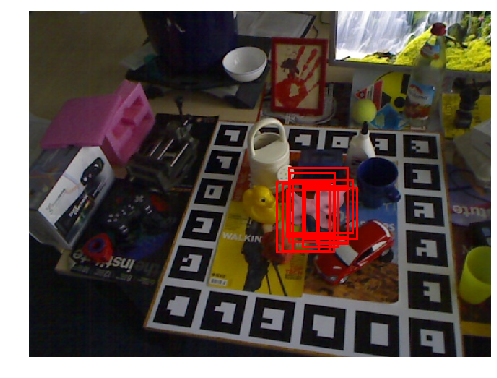

In [7]:
#plt.rcParams['figure.figsize'] = (10, 10)
#plt.imshow(im[:, :, (2, 1, 0)])
#boxes_num = boxes.shape[0]
#for i in range(0,10):
#    bbox = boxes[i] 
#    plt.gca().add_patch(
#        plt.Rectangle((bbox[0], bbox[1]),
#                        bbox[2] - bbox[0],
#                        bbox[3] - bbox[1], fill=False,
#                        edgecolor='g', linewidth=2)
#                        )
#plt.show()

im_s = im[:, :, (2, 1, 0)]
im_h = im.shape[0]
im_w = im.shape[1]
DPI = 100.0
fig, ax = plt.subplots(figsize=(im_w/DPI, im_h/DPI))
ax.imshow(im_s, aspect='equal')
for i in range(0,10):
    bbox = boxes[i]
    ax.add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                        bbox[2] - bbox[0],
                        bbox[3] - bbox[1], fill=False,
                        edgecolor='red', linewidth=2.0)
                )
plt.axis('off')
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0)
plt.draw()


#plt.savefig('rp_overlap.png', dpi=100)